In [1]:
%matplotlib inline

In [2]:
import cv2
import time
import json
import affine
import rasterio
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

import logging

plt.rcParams['image.cmap'] = 'gray'

def show_image(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.show()
    
def read_image(path):
    with rasterio.drivers():
        with rasterio.open(path) as src:
            r, g, b = src.read()
            grayscale = np.uint8(r * 0.2989 +  g * 0.5870 + b * 0.1140)
            profile = src.profile
            return (grayscale, profile)

### I. Read Master and Slave Images

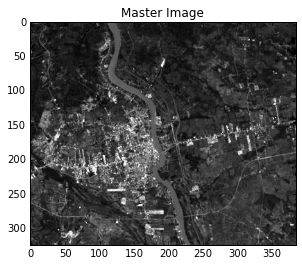

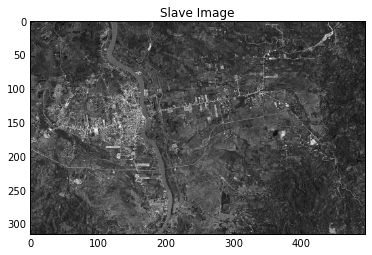

In [3]:
OUTPUT_IMAGE_PATH = 'images/outputs/Butuan.Slave.02.Georefenced.tiff'
MASTER_IMAGE_PATH = 'images/Butuan.Master.jpg'
SLAVE_IMAGE_PATH = 'images/Butuan.Slave.02.jpg'

master_image, master_image_profile = read_image(MASTER_IMAGE_PATH)
slave_image, slave_image_profile = read_image(SLAVE_IMAGE_PATH)

show_image(master_image, "Master Image")
show_image(slave_image, "Slave Image")

### II. Keypoint Matching

In [4]:
surf = cv2.SURF(900)   # keypoint detector and descriptor
bf = cv2.BFMatcher()   # keypoint matcher

#### Extract keypoints from both master and slave images 

In [5]:
k1, d1 = surf.detectAndCompute(master_image, None)
k2, d2 = surf.detectAndCompute(slave_image, None)

#### Compute matches
Compute matches between the two set of keypoints, then filter out the matches based on a distance threshold

In [6]:
matches = bf.match(d1, d2)

dist = [m.distance for m in matches]
distance_threshold =(sum(dist) / len(dist)) * 0.63

sel_matches = [m for m in matches if m.distance < distance_threshold]

print 'Matches:', len(matches)
print 'Distance: min: %.3f' % min(dist)
print 'Distance: mean: %.3f' % (sum(dist) / len(dist))
print 'Distance: max: %.3f' % max(dist)
print 'Selected matches:', len(sel_matches)

Matches: 424
Distance: min: 0.216
Distance: mean: 0.461
Distance: max: 0.666
Selected matches: 11


#### Extract image coordinates of matches

In [7]:
master_keypoints = np.array([ k1[m.queryIdx].pt for m in sel_matches], dtype=np.float32)
slave_keypoints = np.array([ k2[m.trainIdx].pt for m in sel_matches], dtype=np.float32)

print master_keypoints

[[ 154.45574951  156.1410675 ]
 [ 352.19265747  116.69509125]
 [  22.6054821   133.97195435]
 [ 123.4826889   238.35855103]
 [ 186.69699097  161.59754944]
 [  83.33209229  119.56005096]
 [  99.64161682  209.7276001 ]
 [ 163.25108337  301.70385742]
 [ 315.24084473  194.51998901]
 [ 162.31628418  120.71472931]
 [ 194.10011292  144.2116394 ]]


#### Visualize Matches

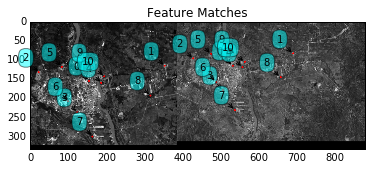

In [8]:
h1, w1 = master_image.shape[:2]
h2, w2 = slave_image.shape[:2]

output_image = sp.zeros((max(h1, h2) + 10, w1 + w2, 3), sp.uint8)
output_image[:h1, :w1, 0] = master_image
output_image[:h2, w1:, 0] = slave_image
output_image[:, :, 1] = output_image[:, :, 0]
output_image[:, :, 2] = output_image[:, :, 0]

cols1 = master_image.shape[1]
cols2 = slave_image.shape[1]

for mat in sel_matches:
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx

    (x1, y1) = k1[img1_idx].pt
    (x2, y2) = k2[img2_idx].pt

    cv2.circle(output_image, (int(x1),int(y1)), 1, (255, 0, 0), 2)   
    cv2.circle(output_image, (int(x2) + cols1,int(y2)), 1, (255, 0, 0), 2)

labels = ['{0}'.format(i) for i in xrange(len(master_keypoints))]
plt.subplots_adjust(bottom = 0)
for label, x, y in zip(labels, master_keypoints[:, 0], master_keypoints[:, 1]):
    plt.annotate( 
        label, xy=(x, y), xytext = (-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox={'boxstyle': 'round4,pad=0.5', 'fc': 'cyan', 'alpha': 0.5},
        arrowprops={'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0'})

plt.subplots_adjust(bottom=0)
for label, x, y in zip(labels, (slave_keypoints[:, 0] + cols1), slave_keypoints[:, 1]):
    plt.annotate(
        label, xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox={'boxstyle': 'round4,pad=0.5', 'fc': 'cyan', 'alpha': 0.5},
        arrowprops={'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0'})
    
show_image(output_image, "Feature Matches")

## III. Georeference Slave Image
Use feature matches to compute global coordinates within the slave image

In [9]:
c1, a1, b1, f1, d1, e1 = master_image_profile['transform']

#### Compute the global coordinates of the keypoints in the master image

In [10]:
x_value = master_keypoints[:, 0]
y_value = master_keypoints[:, 1]

xp = a1 * x_value + b1 * y_value + a1 * 0.5 + b1 * 0.5 + c1
yp = d1 * x_value + e1 * y_value + d1 * 0.5 + e1 * 0.5 + f1

master_gcoords = np.array([xp, yp], dtype=np.float32).T

#### Compute for Affine Transform Parameters

In [11]:
def get_affine_parameters(master_gcoords, slave_pcoords):
    """
    :returns: affine.Affine
    """
    
    gdal_gcps = []

    for i in xrange(len(master_gcoords)):
        gcp = gdal.GCP()
        gcp.GCPX = float(master_gcoords[i][0])
        gcp.GCPY = float(master_gcoords[i][1])
        gcp.GCPPixel = float(slave_keypoints[i][0])
        gcp.GCPLine = float(slave_keypoints[i][1])
        gdal_gcps.append(gcp)

    affine_params = gdal.GCPsToGeoTransform(gdal_gcps)
    return affine.Affine.from_gdal(*affine_params)

slave_affine = get_affine_parameters(master_gcoords, slave_keypoints)

#### Check Affine of Master against Slave
Values for top corners should match

In [12]:
master_image_profile['affine']

Affine(1.1016563707e-07, 0.0, 125.52501375617767,
       0.0, -6.991878683e-08, 9.002214933701698)

In [13]:
slave_affine

Affine(1.5504582029358822e-07, 5.1053804711227226e-09, 125.52500977669845,
       2.4790759960318666e-10, -8.543464192462979e-08, 9.002214198602617)

### IV. Save GeoReferenced Image
To preserve bands of the slave image, we load the file again, update its profile, then save the updated image into a different TIFF file.

In [14]:
slave_image_profile.update(
    count=3,
    transform=slave_affine,
    driver='GTiff'
)

with rasterio.open(SLAVE_IMAGE_PATH) as slave_rgb: 
    with rasterio.open(OUTPUT_IMAGE_PATH, 'w', **slave_image_profile) as dst:
        dst.write(slave_rgb.read())

---

## Checks

#### Visual check of grayscale

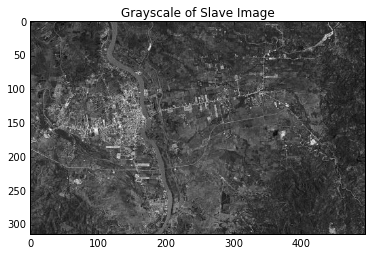

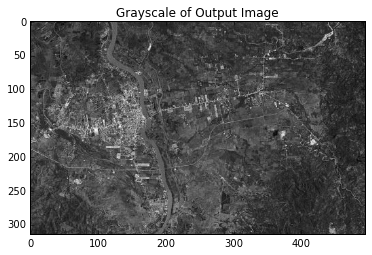

In [15]:
output_image, output_image_profile = read_image(OUTPUT_IMAGE_PATH)
show_image(slave_image, "Grayscale of Slave Image")
show_image(output_image, "Grayscale of Output Image")

#### Check profiles

In [16]:
output_image_profile

{'affine': Affine(1.5504582029358822e-07, 5.1053804711227226e-09, 125.52500977669845,
       2.4790759960318666e-10, -8.543464192462979e-08, 9.002214198602617),
 u'blockxsize': 495,
 u'blockysize': 1,
 'count': 3,
 'crs': {},
 'driver': u'GTiff',
 'dtype': 'uint8',
 'height': 314,
 'nodata': None,
 u'tiled': False,
 'transform': (125.52500977669845,
  1.5504582029358822e-07,
  5.1053804711227226e-09,
  9.002214198602617,
  2.4790759960318666e-10,
  -8.543464192462979e-08),
 'width': 495}

In [17]:
master_image_profile

{'affine': Affine(1.1016563707e-07, 0.0, 125.52501375617767,
       0.0, -6.991878683e-08, 9.002214933701698),
 'blockxsize': 385,
 'blockysize': 1,
 'count': 3,
 'crs': {},
 'driver': u'JPEG',
 'dtype': 'uint8',
 'height': 324,
 'nodata': None,
 'tiled': False,
 'transform': (125.52501375617767,
  1.1016563707e-07,
  0.0,
  9.002214933701698,
  0.0,
  -6.991878683e-08),
 'width': 385}